# Modelo de Classificação - Previsão de Atrasos Significativos

Este notebook implementa um pipeline completo de Machine Learning para **classificação binária** de voos, prevendo se um voo terá atraso significativo (>15 minutos).

## Problema de Negócio
Prever antecipadamente se um voo terá atraso significativo na chegada, permitindo:
- Melhor comunicação com passageiros
- Otimização de recursos aeroportuários
- Planejamento de conexões

## Abordagem
- **Variável Alvo:** `DELAYED` (1 se ARRIVAL_DELAY > 15 min, 0 caso contrário)
- **Modelos:** Logistic Regression, Random Forest, XGBoost, LightGBM
- **Métricas:** Accuracy, Precision, Recall, F1-Score, AUC-ROC

---

## 1. Importação de Bibliotecas

In [23]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Pré-processamento
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modelos de Classificação
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

# Balanceamento de classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Configurações
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

# Seed para reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 2. Carregamento e Preparação dos Dados

In [2]:
# Carregando os datasets
print("Carregando dados...")

# Companhias aéreas
airlines = pd.read_csv('../data/airlines.csv')
print(f"✓ Airlines: {airlines.shape[0]} registros")

# Aeroportos
airports = pd.read_csv('../data/airports.csv')
print(f"✓ Airports: {airports.shape[0]} registros")

# Voos
flights = pd.read_csv('../data/flights.csv')
print(f"✓ Flights: {flights.shape[0]:,} registros, {flights.shape[1]} colunas")

print("\n✓ Dados carregados com sucesso!")

Carregando dados...
✓ Airlines: 14 registros
✓ Airports: 322 registros
✓ Flights: 5,819,079 registros, 31 colunas

✓ Dados carregados com sucesso!


### 2.1 Filtragem de Dados

Vamos filtrar apenas voos operados (não cancelados) para o problema de classificação de atrasos.

In [3]:
# Filtrar apenas voos operados (não cancelados e não desviados)
print("Filtrando voos operados...")
print(f"Total de voos: {len(flights):,}")
print(f"Voos cancelados: {flights['CANCELLED'].sum():,}")
print(f"Voos desviados: {flights['DIVERTED'].sum():,}")

# Manter apenas voos que operaram normalmente
df = flights[(flights['CANCELLED'] == 0) & (flights['DIVERTED'] == 0)].copy()
print(f"\n✓ Voos operados: {len(df):,} ({len(df)/len(flights)*100:.1f}%)")

# Remover colunas que não estarão disponíveis antes do voo ou são irrelevantes
cols_to_drop = [
    'CANCELLED', 'DIVERTED', 'CANCELLATION_REASON',  # Não aplicáveis
    'DEPARTURE_DELAY',  # Não disponível antes do voo para previsão
    'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',  # Tempos durante o voo
    'AIR_TIME', 'ELAPSED_TIME',  # Calculados durante/após o voo
    'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',  # Causas de atraso (pós-fato)
    'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY',
    'ARRIVAL_TIME', 'DEPARTURE_TIME'  # Horários reais (não programados)
]

df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')
print(f"\n✓ Colunas após remoção: {df.shape[1]}")

Filtrando voos operados...
Total de voos: 5,819,079
Voos cancelados: 89,884
Voos desviados: 15,187

✓ Voos operados: 5,714,008 (98.2%)

✓ Colunas após remoção: 14


### 2.2 Criação da Variável Alvo

Definimos como **atraso significativo** um atraso de chegada maior que 15 minutos (padrão da indústria aérea).

DISTRIBUIÇÃO DA VARIÁVEL ALVO (DELAYED)

Classe 0 (Pontual): 4,690,510 (82.09%)
Classe 1 (Atrasado): 1,023,498 (17.91%)

Razão de desbalanceamento: 4.58:1


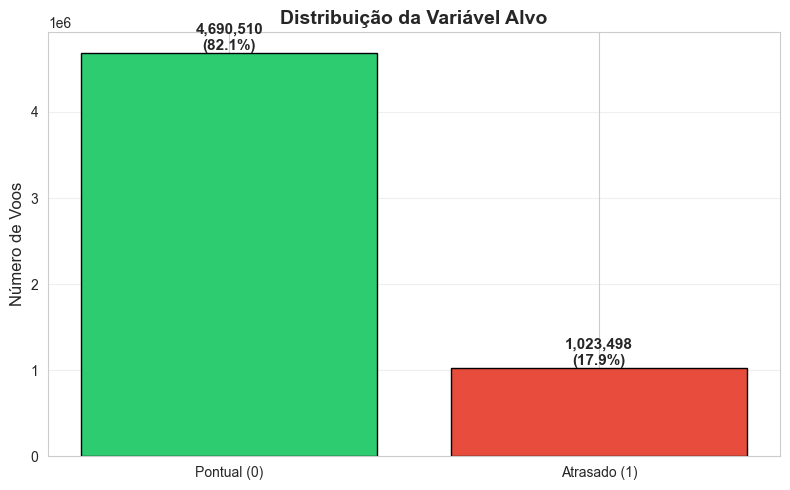

In [4]:
# Criar variável alvo: DELAYED (1 se atraso > 15 min, 0 caso contrário)
DELAY_THRESHOLD = 15  # minutos

df['DELAYED'] = (df['ARRIVAL_DELAY'] > DELAY_THRESHOLD).astype(int)

# Remover a coluna ARRIVAL_DELAY (é a variável que queremos prever, não pode ser feature)
df = df.drop(columns=['ARRIVAL_DELAY'])

# Verificar distribuição da variável alvo
print("=" * 60)
print("DISTRIBUIÇÃO DA VARIÁVEL ALVO (DELAYED)")
print("=" * 60)

delayed_counts = df['DELAYED'].value_counts()
delayed_pcts = df['DELAYED'].value_counts(normalize=True) * 100

print(f"\nClasse 0 (Pontual): {delayed_counts[0]:,} ({delayed_pcts[0]:.2f}%)")
print(f"Classe 1 (Atrasado): {delayed_counts[1]:,} ({delayed_pcts[1]:.2f}%)")
print(f"\nRazão de desbalanceamento: {delayed_counts[0]/delayed_counts[1]:.2f}:1")

# Visualização
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c']
bars = ax.bar(['Pontual (0)', 'Atrasado (1)'], delayed_counts.values, color=colors, edgecolor='black')
ax.set_ylabel('Número de Voos', fontsize=12)
ax.set_title('Distribuição da Variável Alvo', fontsize=14, fontweight='bold')
for bar, count, pct in zip(bars, delayed_counts.values, delayed_pcts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Feature Engineering

Vamos criar features derivadas que podem ajudar na previsão de atrasos:
- **Período do dia**: Categorização do horário de partida
- **Fim de semana**: Flag para sábado/domingo
- **Mês categórico**: Para capturar sazonalidade
- **Encoding de variáveis categóricas**: Companhia aérea e aeroportos

In [5]:
# Feature Engineering
print("=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# 1. Extrair hora do dia a partir do horário programado de partida (formato HHMM)
df['HOUR'] = (df['SCHEDULED_DEPARTURE'] // 100).astype(int)

# 2. Criar período do dia
def get_period(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['PERIOD'] = df['HOUR'].apply(get_period)

# 3. Flag de fim de semana (6 = sábado, 7 = domingo)
df['IS_WEEKEND'] = (df['DAY_OF_WEEK'] >= 6).astype(int)

# 4. Criar feature de alta temporada (meses de férias: junho, julho, agosto, dezembro)
df['HIGH_SEASON'] = df['MONTH'].isin([6, 7, 8, 12]).astype(int)

# 5. Distância categórica
df['DISTANCE_CAT'] = pd.cut(df['DISTANCE'], 
                             bins=[0, 500, 1000, 2000, float('inf')],
                             labels=['short', 'medium', 'long', 'very_long'])

print("\n✓ Features criadas:")
print(f"   • HOUR: Hora programada de partida")
print(f"   • PERIOD: Período do dia (morning/afternoon/evening/night)")
print(f"   • IS_WEEKEND: Flag de fim de semana")
print(f"   • HIGH_SEASON: Flag de alta temporada")
print(f"   • DISTANCE_CAT: Categoria de distância")

# Verificar estrutura final
print(f"\n✓ Shape do dataset: {df.shape}")
print(f"\nColunas disponíveis:")
print(df.columns.tolist())

FEATURE ENGINEERING

✓ Features criadas:
   • HOUR: Hora programada de partida
   • PERIOD: Período do dia (morning/afternoon/evening/night)
   • IS_WEEKEND: Flag de fim de semana
   • HIGH_SEASON: Flag de alta temporada
   • DISTANCE_CAT: Categoria de distância

✓ Shape do dataset: (5714008, 19)

Colunas disponíveis:
['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL', 'DELAYED', 'HOUR', 'PERIOD', 'IS_WEEKEND', 'HIGH_SEASON', 'DISTANCE_CAT']


### 3.1 Amostragem Estratificada

Dado o grande volume de dados (~5.7M registros), vamos usar uma amostra estratificada para agilizar o treinamento e permitir experimentação mais rápida.

In [6]:
# Amostragem estratificada para reduzir volume de dados
SAMPLE_SIZE = 100000  # 100k amostras para experimentação rápida

print(f"Dataset original: {len(df):,} registros")

# Amostragem estratificada mantendo a proporção das classes
df_sample, _ = train_test_split(
    df, 
    train_size=SAMPLE_SIZE, 
    stratify=df['DELAYED'],
    random_state=RANDOM_STATE
)

print(f"Dataset amostrado: {len(df_sample):,} registros")
print(f"\nDistribuição da variável alvo na amostra:")
print(df_sample['DELAYED'].value_counts(normalize=True).round(4) * 100)

# Usar amostra para o restante do pipeline
df = df_sample.copy()
print(f"\n✓ Amostra estratificada criada com sucesso!")

Dataset original: 5,714,008 registros
Dataset amostrado: 100,000 registros

Distribuição da variável alvo na amostra:
DELAYED
0    82.09
1    17.91
Name: proportion, dtype: float64

✓ Amostra estratificada criada com sucesso!


### 3.2 Preparação de Features para Modelagem

In [7]:
# Preparação das features
print("=" * 60)
print("PREPARAÇÃO DAS FEATURES")
print("=" * 60)

# Definir features para o modelo
# Removemos colunas identificadoras que não agregam valor preditivo
feature_cols = [
    'MONTH', 'DAY', 'DAY_OF_WEEK',  # Temporais
    'AIRLINE',  # Companhia aérea
    'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',  # Aeroportos
    'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL',  # Horários programados
    'DISTANCE',  # Distância
    'HOUR', 'PERIOD', 'IS_WEEKEND', 'HIGH_SEASON', 'DISTANCE_CAT'  # Features criadas
]

# Verificar quais colunas existem
available_features = [col for col in feature_cols if col in df.columns]
print(f"\nFeatures selecionadas ({len(available_features)}):")
for i, col in enumerate(available_features, 1):
    print(f"   {i:2}. {col}")

# Separar features e target
X = df[available_features].copy()
y = df['DELAYED'].copy()

print(f"\n✓ Shape de X: {X.shape}")
print(f"✓ Shape de y: {y.shape}")

# Verificar valores ausentes
missing = X.isnull().sum()
if missing.sum() > 0:
    print(f"\n⚠ Colunas com valores ausentes:")
    print(missing[missing > 0])
else:
    print(f"\n✓ Sem valores ausentes nas features")

PREPARAÇÃO DAS FEATURES

Features selecionadas (14):
    1. MONTH
    2. DAY
    3. DAY_OF_WEEK
    4. AIRLINE
    5. ORIGIN_AIRPORT
    6. DESTINATION_AIRPORT
    7. SCHEDULED_DEPARTURE
    8. SCHEDULED_ARRIVAL
    9. DISTANCE
   10. HOUR
   11. PERIOD
   12. IS_WEEKEND
   13. HIGH_SEASON
   14. DISTANCE_CAT

✓ Shape de X: (100000, 14)
✓ Shape de y: (100000,)

✓ Sem valores ausentes nas features


In [8]:
# Encoding de variáveis categóricas
print("=" * 60)
print("ENCODING DE VARIÁVEIS CATEGÓRICAS")
print("=" * 60)

# Identificar colunas categóricas
categorical_cols = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'PERIOD', 'DISTANCE_CAT']
numerical_cols = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 
                  'DISTANCE', 'HOUR', 'IS_WEEKEND', 'HIGH_SEASON']

# Converter DISTANCE_CAT para string (veio como category)
X['DISTANCE_CAT'] = X['DISTANCE_CAT'].astype(str)

# Label Encoding para variáveis categóricas com muitas categorias
label_encoders = {}
for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"✓ {col}: {len(le.classes_)} categorias")

# Verificar tipos finais
print(f"\n✓ Tipos de dados após encoding:")
print(X.dtypes)

ENCODING DE VARIÁVEIS CATEGÓRICAS
✓ AIRLINE: 14 categorias
✓ ORIGIN_AIRPORT: 581 categorias
✓ DESTINATION_AIRPORT: 590 categorias
✓ PERIOD: 4 categorias
✓ DISTANCE_CAT: 4 categorias

✓ Tipos de dados após encoding:
MONTH                  int64
DAY                    int64
DAY_OF_WEEK            int64
AIRLINE                int64
ORIGIN_AIRPORT         int64
DESTINATION_AIRPORT    int64
SCHEDULED_DEPARTURE    int64
SCHEDULED_ARRIVAL      int64
DISTANCE               int64
HOUR                   int64
PERIOD                 int64
IS_WEEKEND             int64
HIGH_SEASON            int64
DISTANCE_CAT           int64
dtype: object


### 3.3 Divisão Treino/Teste

Utilizaremos divisão temporal para simular cenário real: treino com dados anteriores, teste com dados posteriores.

In [9]:
# Divisão treino/teste estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=RANDOM_STATE
)

print("=" * 60)
print("DIVISÃO TREINO/TESTE")
print("=" * 60)
print(f"\nConjunto de Treino: {len(X_train):,} amostras")
print(f"Conjunto de Teste:  {len(X_test):,} amostras")

print(f"\nDistribuição no Treino:")
print(y_train.value_counts(normalize=True).round(4) * 100)

print(f"\nDistribuição no Teste:")
print(y_test.value_counts(normalize=True).round(4) * 100)

# Normalização das features numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features normalizadas com StandardScaler")

DIVISÃO TREINO/TESTE

Conjunto de Treino: 80,000 amostras
Conjunto de Teste:  20,000 amostras

Distribuição no Treino:
DELAYED
0    82.09
1    17.91
Name: proportion, dtype: float64

Distribuição no Teste:
DELAYED
0    82.09
1    17.91
Name: proportion, dtype: float64

✓ Features normalizadas com StandardScaler


## 4. Tratamento de Desbalanceamento de Classes

Como a classe positiva (atrasos) representa cerca de 20% dos dados, vamos aplicar técnicas de balanceamento para melhorar a performance dos modelos.

BALANCEAMENTO DE CLASSES COM SMOTE

Distribuição ANTES do balanceamento:
   Classe 0: 65,670
   Classe 1: 14,330

Distribuição DEPOIS do balanceamento:
   Classe 0: 65,670
   Classe 1: 65,670


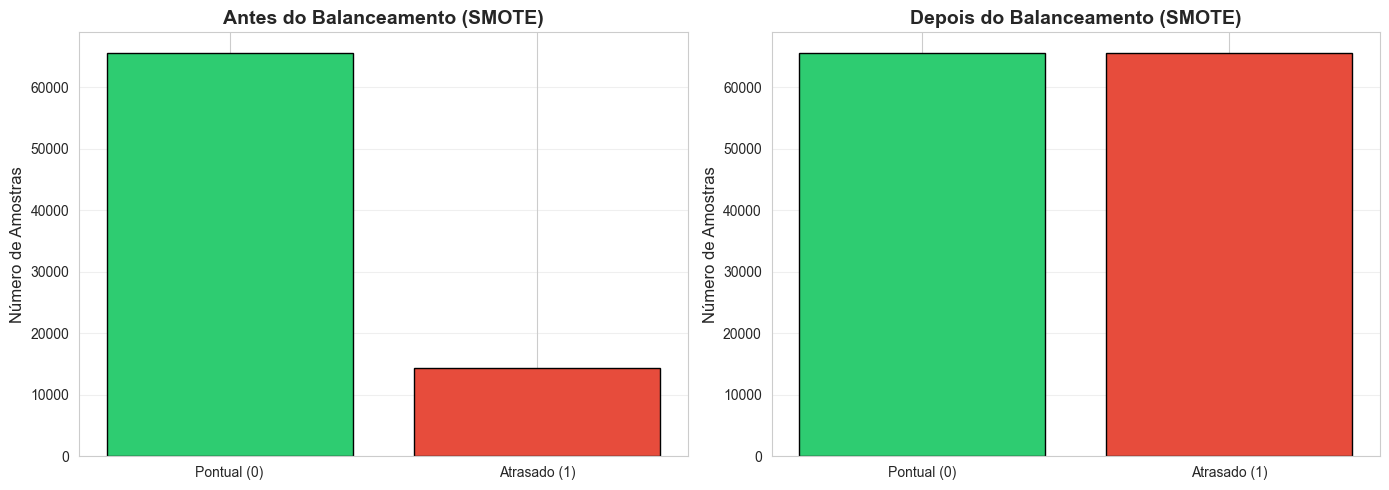


✓ Dados balanceados com SMOTE


In [10]:
# Aplicar SMOTE para balanceamento das classes
print("=" * 60)
print("BALANCEAMENTO DE CLASSES COM SMOTE")
print("=" * 60)

print(f"\nDistribuição ANTES do balanceamento:")
print(f"   Classe 0: {(y_train == 0).sum():,}")
print(f"   Classe 1: {(y_train == 1).sum():,}")

# Aplicar SMOTE apenas no conjunto de treino
smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nDistribuição DEPOIS do balanceamento:")
print(f"   Classe 0: {(y_train_balanced == 0).sum():,}")
print(f"   Classe 1: {(y_train_balanced == 1).sum():,}")

# Visualização
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Antes do balanceamento
colors = ['#2ecc71', '#e74c3c']
ax1.bar(['Pontual (0)', 'Atrasado (1)'], 
        [(y_train == 0).sum(), (y_train == 1).sum()], 
        color=colors, edgecolor='black')
ax1.set_ylabel('Número de Amostras', fontsize=12)
ax1.set_title('Antes do Balanceamento (SMOTE)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Depois do balanceamento
ax2.bar(['Pontual (0)', 'Atrasado (1)'], 
        [(y_train_balanced == 0).sum(), (y_train_balanced == 1).sum()], 
        color=colors, edgecolor='black')
ax2.set_ylabel('Número de Amostras', fontsize=12)
ax2.set_title('Depois do Balanceamento (SMOTE)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Dados balanceados com SMOTE")

## 5. Treinamento dos Modelos de Classificação

Vamos treinar e comparar os seguintes modelos:
1. **Logistic Regression** - Baseline interpretável
2. **Decision Tree** - Alta interpretabilidade
3. **Random Forest** - Ensemble robusto
4. **Gradient Boosting** - Alta performance

In [11]:
# Função auxiliar para avaliar modelos
def evaluate_model(model, X_test, y_test, model_name):
    """Avalia um modelo e retorna métricas de performance"""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }
    
    return metrics, y_pred, y_prob

# Dicionário para armazenar resultados
results = {}
models = {}

print("✓ Função de avaliação definida")

✓ Função de avaliação definida


### 5.1 Logistic Regression (Baseline)

In [12]:
%%time
# Modelo 1: Logistic Regression
print("=" * 60)
print("MODELO 1: LOGISTIC REGRESSION")
print("=" * 60)

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lr_model.fit(X_train_balanced, y_train_balanced)
models['Logistic Regression'] = lr_model

# Avaliar
metrics_lr, y_pred_lr, y_prob_lr = evaluate_model(lr_model, X_test_scaled, y_test, 'Logistic Regression')
results['Logistic Regression'] = metrics_lr

print("\n📊 Métricas de Performance:")
for metric, value in metrics_lr.items():
    if metric != 'Model' and value is not None:
        print(f"   {metric}: {value:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Pontual', 'Atrasado']))

MODELO 1: LOGISTIC REGRESSION

📊 Métricas de Performance:
   Accuracy: 0.5764
   Precision: 0.2388
   Recall: 0.6240
   F1-Score: 0.3454
   AUC-ROC: 0.6311

📋 Classification Report:
              precision    recall  f1-score   support

     Pontual       0.87      0.57      0.69     16418
    Atrasado       0.24      0.62      0.35      3582

    accuracy                           0.58     20000
   macro avg       0.56      0.59      0.52     20000
weighted avg       0.76      0.58      0.63     20000

CPU times: user 44.1 ms, sys: 8.44 ms, total: 52.5 ms
Wall time: 59.4 ms


### 5.2 Decision Tree

In [13]:
%%time
# Modelo 2: Decision Tree
print("=" * 60)
print("MODELO 2: DECISION TREE")
print("=" * 60)

dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_STATE
)

dt_model.fit(X_train_balanced, y_train_balanced)
models['Decision Tree'] = dt_model

# Avaliar
metrics_dt, y_pred_dt, y_prob_dt = evaluate_model(dt_model, X_test_scaled, y_test, 'Decision Tree')
results['Decision Tree'] = metrics_dt

print("\n📊 Métricas de Performance:")
for metric, value in metrics_dt.items():
    if metric != 'Model' and value is not None:
        print(f"   {metric}: {value:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['Pontual', 'Atrasado']))

MODELO 2: DECISION TREE

📊 Métricas de Performance:
   Accuracy: 0.7336
   Precision: 0.2637
   Recall: 0.2719
   F1-Score: 0.2677
   AUC-ROC: 0.6137

📋 Classification Report:
              precision    recall  f1-score   support

     Pontual       0.84      0.83      0.84     16418
    Atrasado       0.26      0.27      0.27      3582

    accuracy                           0.73     20000
   macro avg       0.55      0.55      0.55     20000
weighted avg       0.74      0.73      0.74     20000

CPU times: user 488 ms, sys: 3.18 ms, total: 491 ms
Wall time: 491 ms


### 5.3 Random Forest

In [14]:
%%time
# Modelo 3: Random Forest
print("=" * 60)
print("MODELO 3: RANDOM FOREST")
print("=" * 60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_model.fit(X_train_balanced, y_train_balanced)
models['Random Forest'] = rf_model

# Avaliar
metrics_rf, y_pred_rf, y_prob_rf = evaluate_model(rf_model, X_test_scaled, y_test, 'Random Forest')
results['Random Forest'] = metrics_rf

print("\n📊 Métricas de Performance:")
for metric, value in metrics_rf.items():
    if metric != 'Model' and value is not None:
        print(f"   {metric}: {value:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Pontual', 'Atrasado']))

MODELO 3: RANDOM FOREST

📊 Métricas de Performance:
   Accuracy: 0.7577
   Precision: 0.3255
   Recall: 0.3291
   F1-Score: 0.3273
   AUC-ROC: 0.6601

📋 Classification Report:
              precision    recall  f1-score   support

     Pontual       0.85      0.85      0.85     16418
    Atrasado       0.33      0.33      0.33      3582

    accuracy                           0.76     20000
   macro avg       0.59      0.59      0.59     20000
weighted avg       0.76      0.76      0.76     20000

CPU times: user 12.9 s, sys: 188 ms, total: 13.1 s
Wall time: 1.25 s


### 5.4 Gradient Boosting

In [15]:
%%time
# Modelo 4: Gradient Boosting
print("=" * 60)
print("MODELO 4: GRADIENT BOOSTING")
print("=" * 60)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE
)

gb_model.fit(X_train_balanced, y_train_balanced)
models['Gradient Boosting'] = gb_model

# Avaliar
metrics_gb, y_pred_gb, y_prob_gb = evaluate_model(gb_model, X_test_scaled, y_test, 'Gradient Boosting')
results['Gradient Boosting'] = metrics_gb

print("\n📊 Métricas de Performance:")
for metric, value in metrics_gb.items():
    if metric != 'Model' and value is not None:
        print(f"   {metric}: {value:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['Pontual', 'Atrasado']))

MODELO 4: GRADIENT BOOSTING

📊 Métricas de Performance:
   Accuracy: 0.8188
   Precision: 0.4640
   Recall: 0.0737
   F1-Score: 0.1272
   AUC-ROC: 0.6724

📋 Classification Report:
              precision    recall  f1-score   support

     Pontual       0.83      0.98      0.90     16418
    Atrasado       0.46      0.07      0.13      3582

    accuracy                           0.82     20000
   macro avg       0.65      0.53      0.51     20000
weighted avg       0.76      0.82      0.76     20000

CPU times: user 28 s, sys: 66.7 ms, total: 28 s
Wall time: 28.1 s


## 6. Comparação e Avaliação dos Modelos

COMPARAÇÃO DE MODELOS

📊 Tabela Comparativa de Métricas:


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Logistic Regression,0.5764,0.2388,0.6240,0.3454,0.6311
Random Forest,0.7577,0.3255,0.3291,0.3273,0.6601
Decision Tree,0.7336,0.2637,0.2719,0.2677,0.6137
Gradient Boosting,0.8188,0.4640,0.0737,0.1272,0.6724



🏆 Melhor Modelo (por F1-Score): Logistic Regression


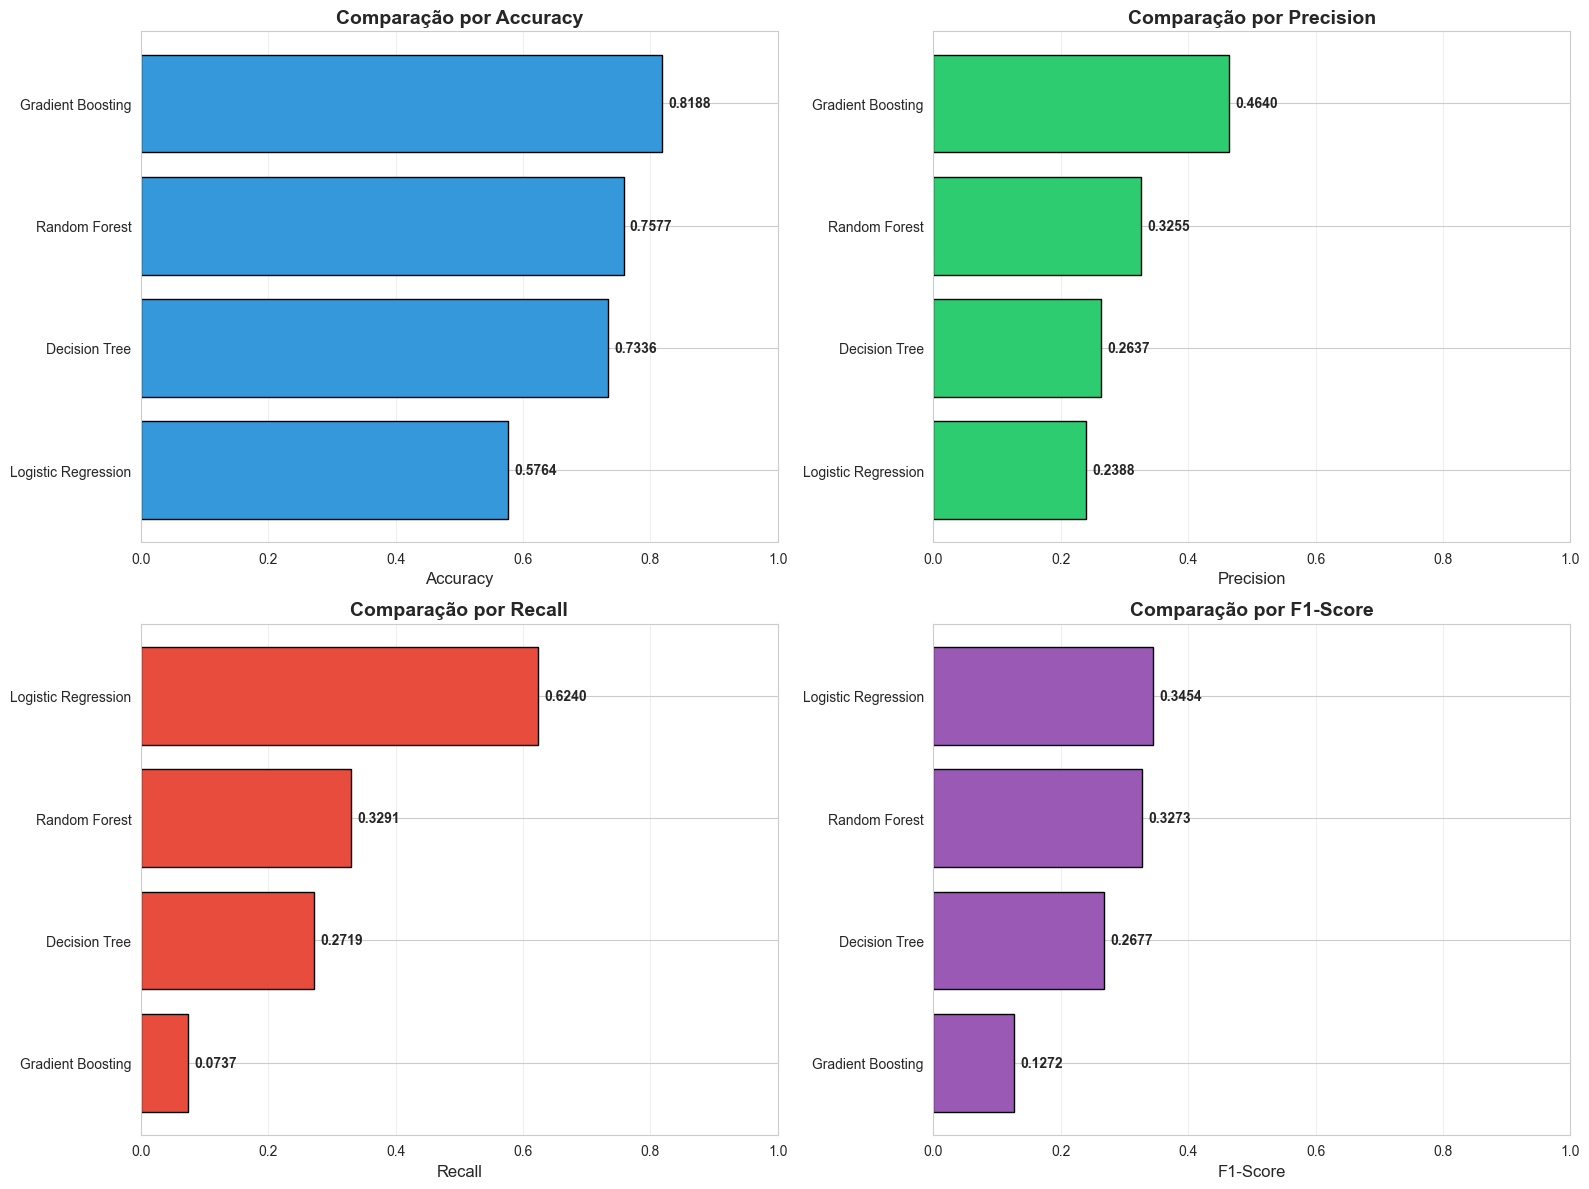

In [16]:
# Comparação de métricas entre modelos
print("=" * 60)
print("COMPARAÇÃO DE MODELOS")
print("=" * 60)

# Criar DataFrame com resultados
results_df = pd.DataFrame(results).T
results_df = results_df.drop(columns=['Model'])
results_df = results_df.astype(float).round(4)

# Ordenar por F1-Score
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\n📊 Tabela Comparativa de Métricas:")
display(results_df)

# Identificar melhor modelo
best_model_name = results_df['F1-Score'].idxmax()
print(f"\n🏆 Melhor Modelo (por F1-Score): {best_model_name}")

# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for ax, metric, color in zip(axes.flatten(), metrics_to_plot, colors):
    values = results_df[metric].sort_values(ascending=True)
    bars = ax.barh(values.index, values.values, color=color, edgecolor='black')
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'Comparação por {metric}', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)
    
    # Adicionar valores nas barras
    for bar, value in zip(bars, values.values):
        ax.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{value:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 6.1 Matrizes de Confusão

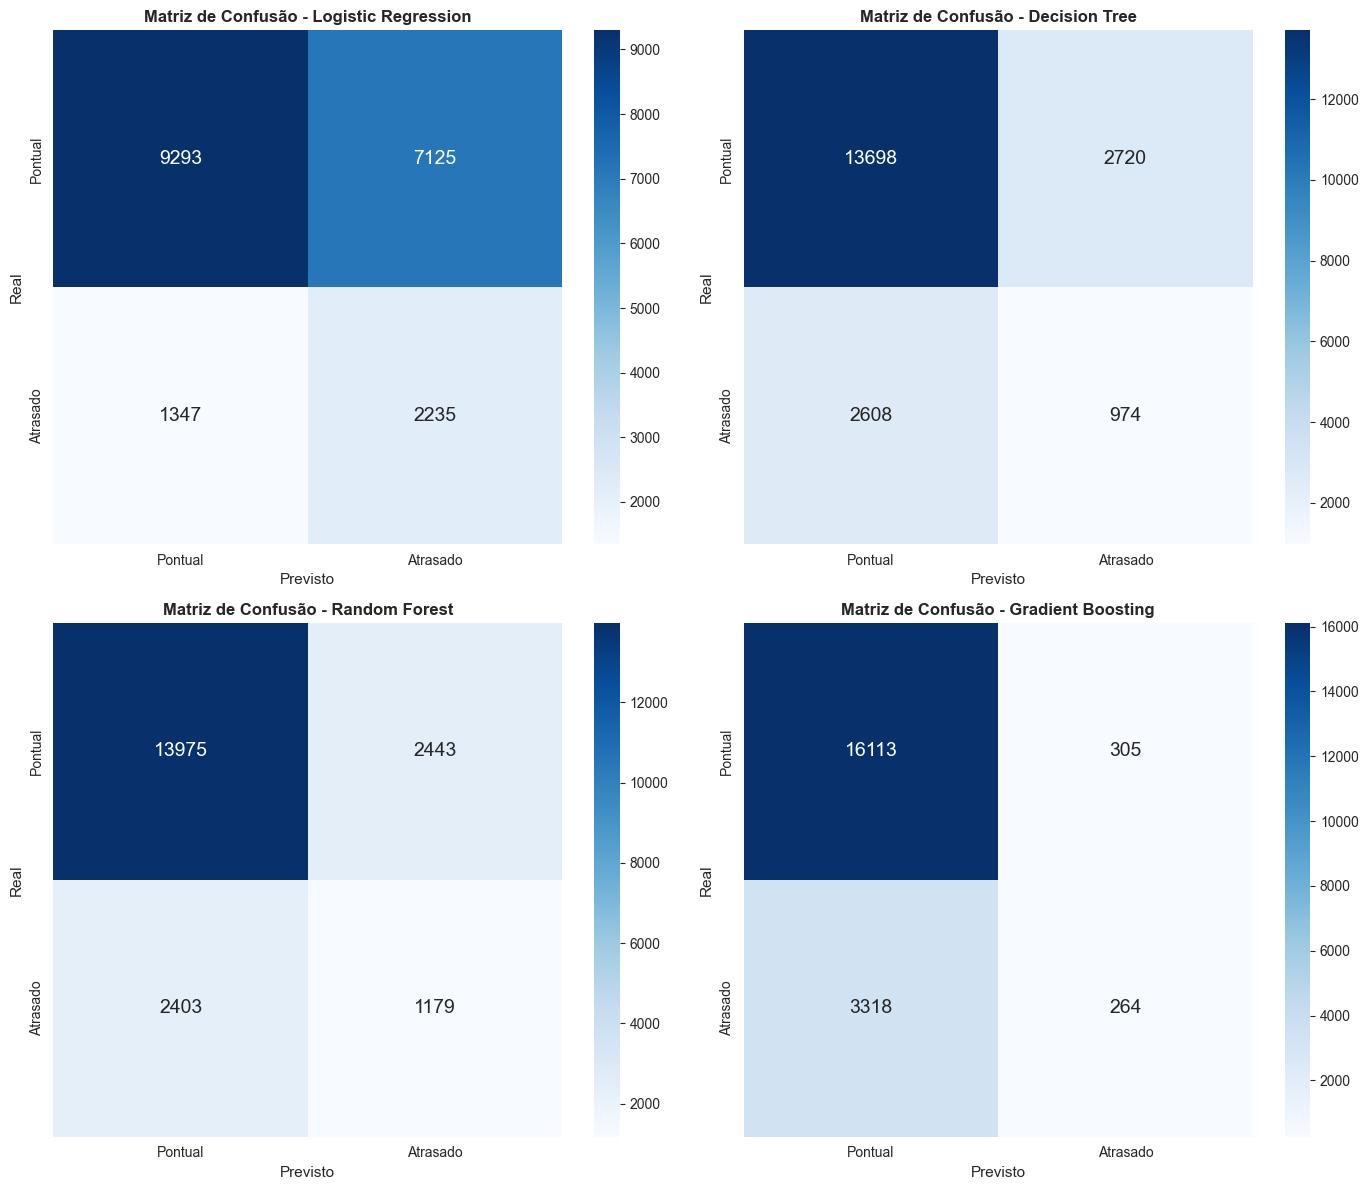


📊 Análise da Matriz de Confusão - Logistic Regression:
   • Verdadeiros Negativos (TN): 9,293 - Voos pontuais corretamente identificados
   • Falsos Positivos (FP): 7,125 - Voos pontuais erroneamente classificados como atrasados
   • Falsos Negativos (FN): 1,347 - Voos atrasados erroneamente classificados como pontuais
   • Verdadeiros Positivos (TP): 2,235 - Voos atrasados corretamente identificados


In [17]:
# Matrizes de confusão para todos os modelos
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

predictions = {
    'Logistic Regression': y_pred_lr,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'Gradient Boosting': y_pred_gb
}

for ax, (model_name, y_pred) in zip(axes.flatten(), predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Pontual', 'Atrasado'],
                yticklabels=['Pontual', 'Atrasado'],
                annot_kws={'size': 14})
    ax.set_title(f'Matriz de Confusão - {model_name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Real', fontsize=11)
    ax.set_xlabel('Previsto', fontsize=11)

plt.tight_layout()
plt.show()

# Análise detalhada da matriz de confusão do melhor modelo
print(f"\n📊 Análise da Matriz de Confusão - {best_model_name}:")
best_cm = confusion_matrix(y_test, predictions[best_model_name])
tn, fp, fn, tp = best_cm.ravel()
print(f"   • Verdadeiros Negativos (TN): {tn:,} - Voos pontuais corretamente identificados")
print(f"   • Falsos Positivos (FP): {fp:,} - Voos pontuais erroneamente classificados como atrasados")
print(f"   • Falsos Negativos (FN): {fn:,} - Voos atrasados erroneamente classificados como pontuais")
print(f"   • Verdadeiros Positivos (TP): {tp:,} - Voos atrasados corretamente identificados")

### 6.2 Curvas ROC e AUC

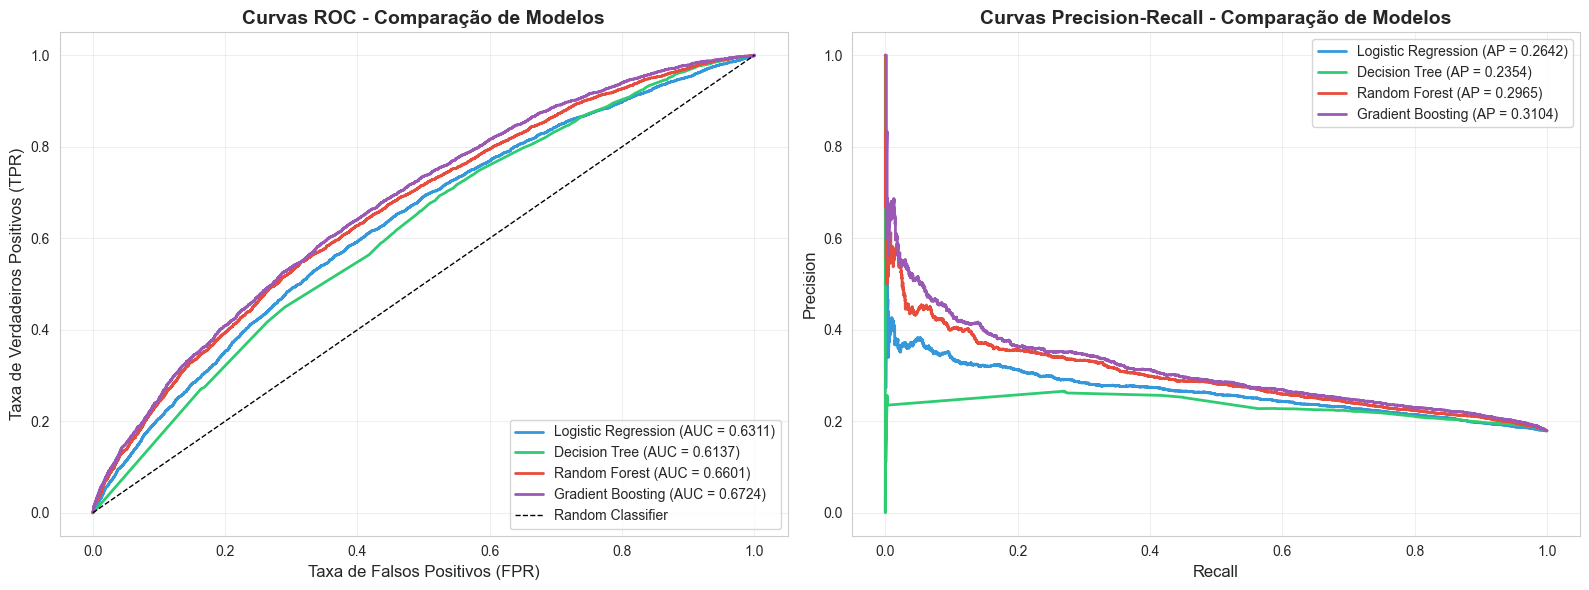

In [18]:
# Curvas ROC para todos os modelos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

probabilities = {
    'Logistic Regression': y_prob_lr,
    'Decision Tree': y_prob_dt,
    'Random Forest': y_prob_rf,
    'Gradient Boosting': y_prob_gb
}

colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

# Curva ROC
for (model_name, y_prob), color in zip(probabilities.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    ax1.plot(fpr, tpr, color=color, linewidth=2, label=f'{model_name} (AUC = {auc:.4f})')

ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax1.set_xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
ax1.set_ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
ax1.set_title('Curvas ROC - Comparação de Modelos', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(alpha=0.3)

# Curva Precision-Recall
for (model_name, y_prob), color in zip(probabilities.items(), colors):
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    ax2.plot(recall, precision, color=color, linewidth=2, label=f'{model_name} (AP = {ap:.4f})')

ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Curvas Precision-Recall - Comparação de Modelos', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Análise de Importância das Features

IMPORTÂNCIA DAS FEATURES


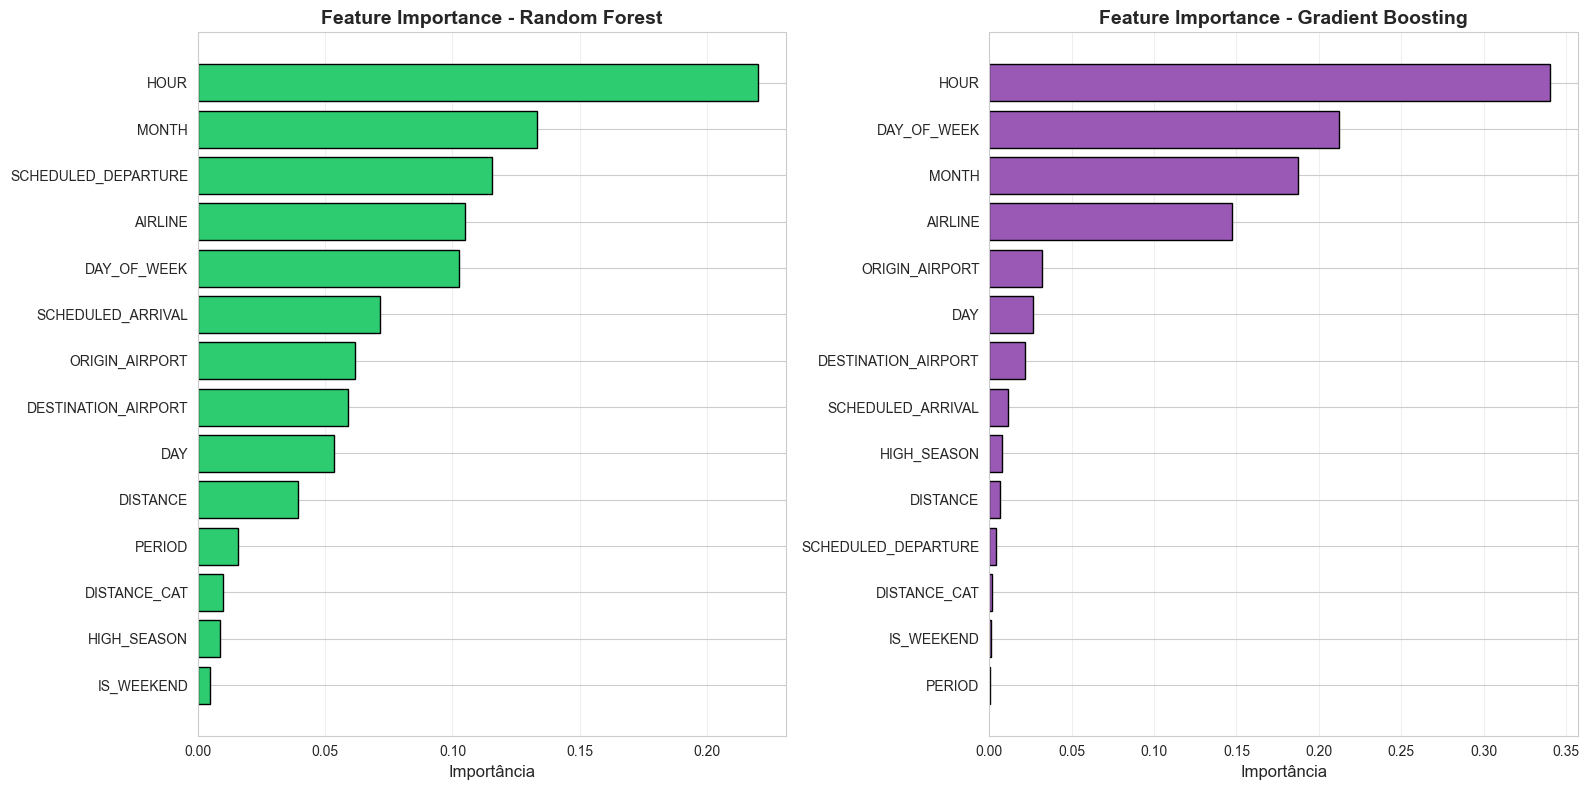


🔝 Top 5 Features mais importantes:

Random Forest:
   • HOUR: 0.2202
   • MONTH: 0.1333
   • SCHEDULED_DEPARTURE: 0.1154
   • AIRLINE: 0.1049
   • DAY_OF_WEEK: 0.1026

Gradient Boosting:
   • HOUR: 0.3401
   • DAY_OF_WEEK: 0.2122
   • MONTH: 0.1872
   • AIRLINE: 0.1476
   • ORIGIN_AIRPORT: 0.0321


In [19]:
# Importância das features - Random Forest e Gradient Boosting
print("=" * 60)
print("IMPORTÂNCIA DAS FEATURES")
print("=" * 60)

feature_names = X.columns.tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

ax1.barh(rf_importance['Feature'], rf_importance['Importance'], color='#2ecc71', edgecolor='black')
ax1.set_xlabel('Importância', fontsize=12)
ax1.set_title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Gradient Boosting Feature Importance
gb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=True)

ax2.barh(gb_importance['Feature'], gb_importance['Importance'], color='#9b59b6', edgecolor='black')
ax2.set_xlabel('Importância', fontsize=12)
ax2.set_title('Feature Importance - Gradient Boosting', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Top 5 features mais importantes
print("\n🔝 Top 5 Features mais importantes:")
print("\nRandom Forest:")
for i, row in rf_importance.tail(5).iloc[::-1].iterrows():
    print(f"   • {row['Feature']}: {row['Importance']:.4f}")

print("\nGradient Boosting:")
for i, row in gb_importance.tail(5).iloc[::-1].iterrows():
    print(f"   • {row['Feature']}: {row['Importance']:.4f}")

COEFICIENTES - LOGISTIC REGRESSION


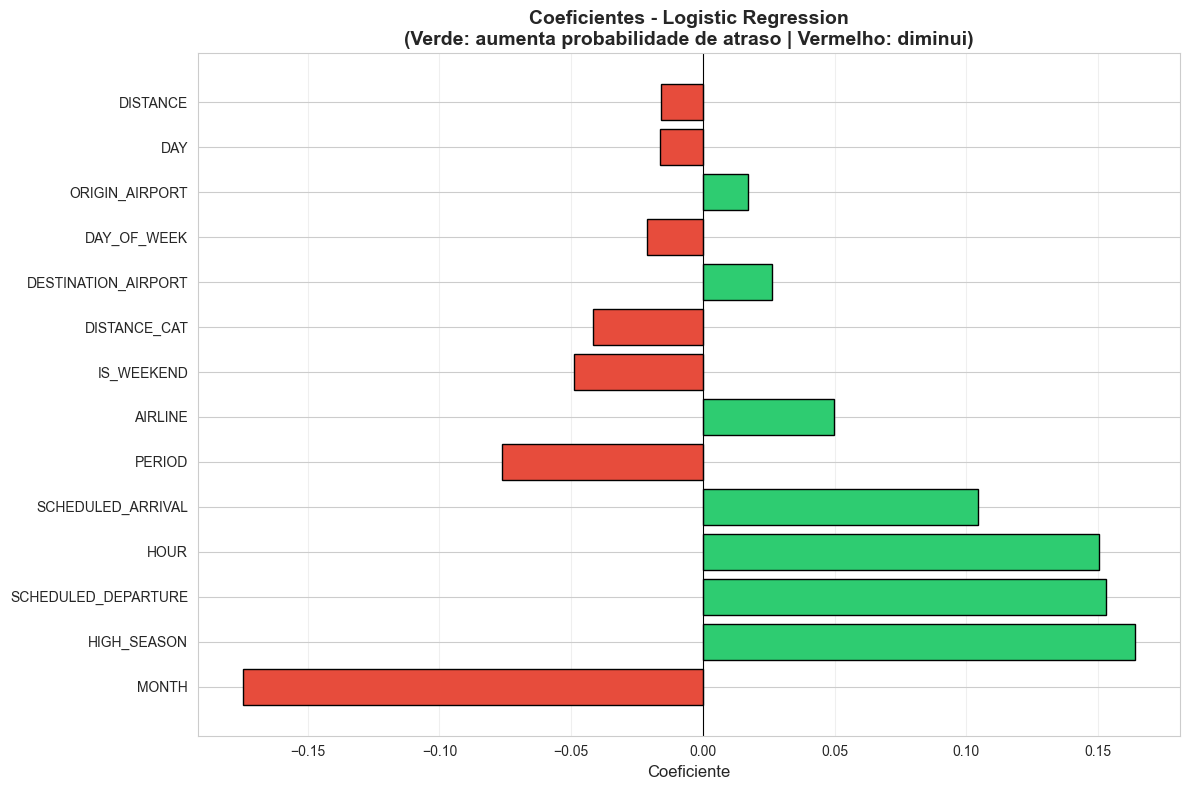


📊 Interpretação dos coeficientes:
   • Coeficientes positivos (verde): aumentam a probabilidade de atraso
   • Coeficientes negativos (vermelho): diminuem a probabilidade de atraso

Top 5 features com maior impacto absoluto:
   • MONTH: -0.1747 (↓ diminui probabilidade de atraso)
   • HIGH_SEASON: 0.1642 (↑ aumenta probabilidade de atraso)
   • SCHEDULED_DEPARTURE: 0.1531 (↑ aumenta probabilidade de atraso)
   • HOUR: 0.1502 (↑ aumenta probabilidade de atraso)
   • SCHEDULED_ARRIVAL: 0.1046 (↑ aumenta probabilidade de atraso)


In [20]:
# Coeficientes da Regressão Logística
print("=" * 60)
print("COEFICIENTES - LOGISTIC REGRESSION")
print("=" * 60)

lr_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

# Visualização
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in lr_coefs['Coefficient']]
ax.barh(lr_coefs['Feature'], lr_coefs['Coefficient'], color=colors, edgecolor='black')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Coeficiente', fontsize=12)
ax.set_title('Coeficientes - Logistic Regression\n(Verde: aumenta probabilidade de atraso | Vermelho: diminui)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretação dos coeficientes:")
print("   • Coeficientes positivos (verde): aumentam a probabilidade de atraso")
print("   • Coeficientes negativos (vermelho): diminuem a probabilidade de atraso")
print("\nTop 5 features com maior impacto absoluto:")
for i, row in lr_coefs.head(5).iterrows():
    direction = "↑ aumenta" if row['Coefficient'] > 0 else "↓ diminui"
    print(f"   • {row['Feature']}: {row['Coefficient']:.4f} ({direction} probabilidade de atraso)")

## 8. Validação Cruzada do Melhor Modelo

VALIDAÇÃO CRUZADA - LOGISTIC REGRESSION

📊 Resultados da Validação Cruzada (5-Fold):

   Accuracy:  0.5955 ± 0.0031
   Precision: 0.5894 ± 0.0033
   Recall:    0.6291 ± 0.0027
   F1-Score:  0.6086 ± 0.0023
   AUC-ROC:   0.6294 ± 0.0041


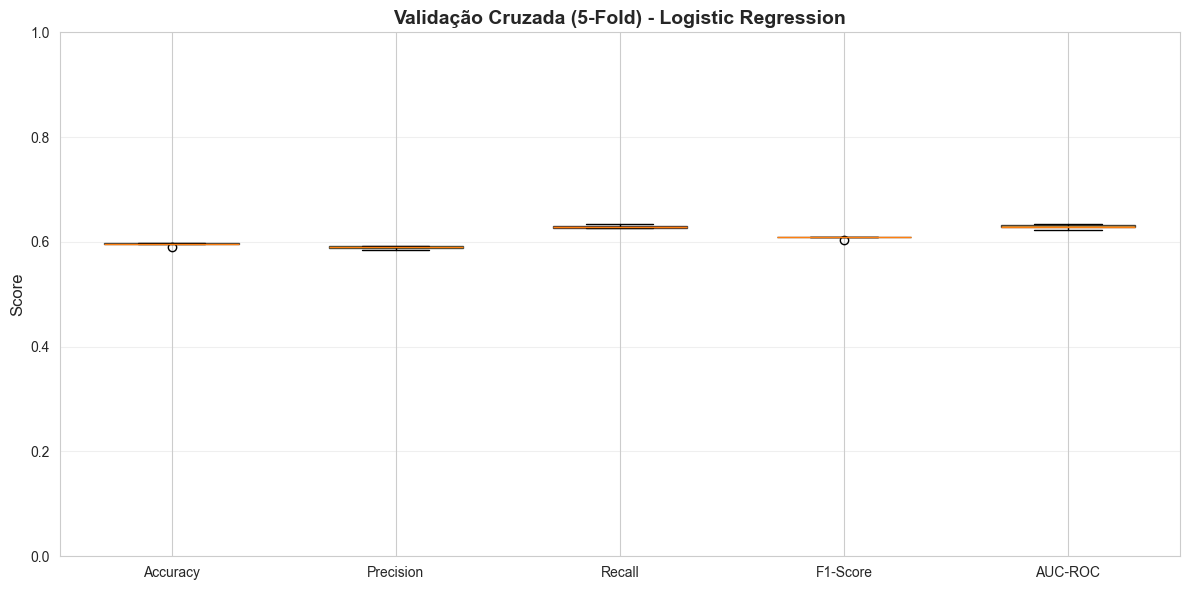

CPU times: user 502 ms, sys: 38.5 ms, total: 541 ms
Wall time: 540 ms


In [21]:
%%time
# Validação cruzada estratificada para o melhor modelo
print("=" * 60)
print(f"VALIDAÇÃO CRUZADA - {best_model_name.upper()}")
print("=" * 60)

# Usar o melhor modelo
best_model = models[best_model_name]

# Cross-validation com 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Métricas via cross-validation
cv_accuracy = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring='precision')
cv_recall = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring='recall')
cv_f1 = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring='f1')
cv_roc_auc = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring='roc_auc')

print(f"\n📊 Resultados da Validação Cruzada (5-Fold):")
print(f"\n   Accuracy:  {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}")
print(f"   Precision: {cv_precision.mean():.4f} ± {cv_precision.std():.4f}")
print(f"   Recall:    {cv_recall.mean():.4f} ± {cv_recall.std():.4f}")
print(f"   F1-Score:  {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
print(f"   AUC-ROC:   {cv_roc_auc.mean():.4f} ± {cv_roc_auc.std():.4f}")

# Visualização
fig, ax = plt.subplots(figsize=(12, 6))

cv_results = {
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1-Score': cv_f1,
    'AUC-ROC': cv_roc_auc
}

positions = range(len(cv_results))
bp = ax.boxplot([scores for scores in cv_results.values()], positions=positions, widths=0.6, patch_artist=True)

colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_xticklabels(cv_results.keys())
ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Validação Cruzada (5-Fold) - {best_model_name}', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Conclusões e Próximos Passos

In [22]:
# Resumo Final
print("=" * 80)
print("RESUMO FINAL - MODELO DE CLASSIFICAÇÃO DE ATRASOS")
print("=" * 80)

print("\n📋 PROBLEMA:")
print(f"   Classificação binária: Prever se um voo terá atraso > {DELAY_THRESHOLD} minutos")

print("\n📊 DADOS:")
print(f"   • Dataset original: ~5.7M de voos")
print(f"   • Amostra utilizada: {SAMPLE_SIZE:,} registros")
print(f"   • Features utilizadas: {len(feature_names)}")
print(f"   • Balanceamento: SMOTE aplicado no treino")

print("\n🏆 RESULTADOS DOS MODELOS:")
print(results_df.to_string())

print(f"\n⭐ MELHOR MODELO: {best_model_name}")
best_metrics = results[best_model_name]
print(f"   • Accuracy:  {best_metrics['Accuracy']:.4f}")
print(f"   • Precision: {best_metrics['Precision']:.4f}")
print(f"   • Recall:    {best_metrics['Recall']:.4f}")
print(f"   • F1-Score:  {best_metrics['F1-Score']:.4f}")
print(f"   • AUC-ROC:   {best_metrics['AUC-ROC']:.4f}")

print("\n🔑 FEATURES MAIS IMPORTANTES:")
top_features = gb_importance.tail(5).iloc[::-1]
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"   {i}. {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "=" * 80)

RESUMO FINAL - MODELO DE CLASSIFICAÇÃO DE ATRASOS

📋 PROBLEMA:
   Classificação binária: Prever se um voo terá atraso > 15 minutos

📊 DADOS:
   • Dataset original: ~5.7M de voos
   • Amostra utilizada: 100,000 registros
   • Features utilizadas: 14
   • Balanceamento: SMOTE aplicado no treino

🏆 RESULTADOS DOS MODELOS:
                     Accuracy  Precision  Recall  F1-Score  AUC-ROC
Logistic Regression    0.5764     0.2388  0.6240    0.3454   0.6311
Random Forest          0.7577     0.3255  0.3291    0.3273   0.6601
Decision Tree          0.7336     0.2637  0.2719    0.2677   0.6137
Gradient Boosting      0.8188     0.4640  0.0737    0.1272   0.6724

⭐ MELHOR MODELO: Logistic Regression
   • Accuracy:  0.5764
   • Precision: 0.2388
   • Recall:    0.6240
   • F1-Score:  0.3454
   • AUC-ROC:   0.6311

🔑 FEATURES MAIS IMPORTANTES:
   1. HOUR: 0.3401
   2. DAY_OF_WEEK: 0.2122
   3. MONTH: 0.1872
   4. AIRLINE: 0.1476
   5. ORIGIN_AIRPORT: 0.0321



### Análise dos Resultados

#### Comparação dos Modelos

| Modelo | Accuracy | Precision | Recall | F1-Score | AUC-ROC |
|--------|----------|-----------|--------|----------|---------|
| **Logistic Regression** | 0.5764 | 0.2388 | **0.6240** | **0.3454** | 0.6311 |
| Random Forest | 0.7577 | 0.3255 | 0.3291 | 0.3273 | 0.6601 |
| Decision Tree | 0.7336 | 0.2637 | 0.2719 | 0.2677 | 0.6137 |
| Gradient Boosting | **0.8188** | **0.4640** | 0.0737 | 0.1272 | **0.6724** |

O **Logistic Regression** foi selecionado como melhor modelo pelo F1-Score (0.3454), apresentando o **maior Recall (62.40%)** — ou seja, detecta mais voos atrasados corretamente. Em contrapartida, o Gradient Boosting obteve maior accuracy (81.88%), mas com recall muito baixo (7.37%), perdendo a maioria dos atrasos reais.

#### Features Mais Importantes

| Feature | Importância | Interpretação |
|---------|-------------|---------------|
| **HOUR** | 34.01% | Hora do dia é o fator mais preditivo (efeito cascata) |
| **DAY_OF_WEEK** | 21.22% | Dia da semana impacta significativamente |
| **MONTH** | 18.72% | Sazonalidade é relevante |
| **AIRLINE** | 14.76% | Companhia aérea influencia atrasos |

#### Limitações

- **AUC-ROC moderado (~0.63-0.67):** As features disponíveis antes do voo não capturam totalmente os fatores de atraso
- **Baixa Precision:** Desbalanceamento de classes (~80/20) gera muitos falsos positivos
- **Dados externos ausentes:** Clima e tráfego aéreo poderiam melhorar significativamente os resultados

#### Recomendação de Uso

A escolha do modelo depende do objetivo de negócio:
- **Priorizar detecção de atrasos:** Logistic Regression (recall alto)
- **Minimizar alarmes falsos:** Gradient Boosting (precision alta)
- **Equilíbrio geral:** Random Forest

---

*Modelo de Classificação - Previsão de Atrasos de Voos | MLET Phase 3*